# Daily Smoke and Asthma Place of Service Analysis <a class="tocSkip">

**Author: Ryan Gan**

**Date Created: 2018-08-12**

Daily time series analysis evaluating the impact of wildfire smoke in Medford on asthma-related claims and pharmacy. 

Loading tidyverse.

In [1]:
# load tidyverse
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.3.0     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::vars()   masks ggplot2::vars()


## Health Outcomes

Load the asthma case-crossover list to extract the events and create time series based on events.

In [2]:
# load asthma casecross place of service list
load("../../data/health/asthma_cc_pos_list.RData")
# extract names
vars_keep <- names(asthma_cc_pos_list[[4]])

Read in SABA case-crossover dataset.

In [3]:
saba <- read_csv("../../data/health/2013-oregon_casecross_saba.csv") %>% 
  rename(identifier = personkey, ZIP = ZIPCODE) %>% 
  mutate(service_place = "SABA Fill",
         dx1 = ndc) %>% 
  # keeping only vars in the other casecrossover dataframes
  dplyr::select(vars_keep, ndc) %>% 
  # turn in to list
  list()

# assign name
names(saba) = "saba"

Parsed with column specification:
cols(
  .default = col_double(),
  personkey = col_integer(),
  clmid = col_integer(),
  num_visit = col_integer(),
  year = col_integer(),
  line = col_integer(),
  clmstatus = col_character(),
  cob = col_character(),
  paytype = col_character(),
  prod = col_character(),
  payer = col_character(),
  ohvmhflag = col_character(),
  pebb = col_integer(),
  oebb = col_integer(),
  patid = col_integer(),
  gender = col_character(),
  yob = col_integer(),
  race = col_integer(),
  ethn = col_integer(),
  lang = col_integer(),
  MSA = col_integer()
  # ... with 51 more columns
)
See spec(...) for full column specifications.


Count up the number of events and create daily time series.

In [4]:
# adding in age category to each dataframe in list 
# (i should have done this earlier)
asthma_pos_count <- c(asthma_cc_pos_list, saba) %>% 
  map_dfr(., function(df){
    return_df <- df %>% 
      # remove unknown gender
      filter(outcome ==1 ) %>% 
      mutate(metroarea = case_when(MSA == 13460 ~ "Bend",
                                MSA == 18700 ~ "Corvallis",
                                MSA == 21660 ~ "Eugene",
                                MSA == 32780 ~ "Medford",
                                MSA == 38900 ~ "Portland",
                                MSA == 41420 ~ "Salem",
                                MSA == 41999 ~ "Not in MSA"),
        service_place = case_when(service_place == "Emergency Room – Hospital" ~ 
                                    "Emergency Department", 
          TRUE ~ service_place)) %>% 
      # group by date, metroarea, and service place
      group_by(date, metroarea, service_place) %>% 
      summarise(n_events = sum(outcome))
  })

Read in MSA population.

In [5]:
# read saba and asthma ed count# read  
population <- read_csv("../../data/health/saba_month_counts.csv") %>% 
  dplyr::select(msa_name, POPESTIMATE2013) %>% 
  rename(metroarea = msa_name,
         pop = POPESTIMATE2013) %>% 
  unique()

Parsed with column specification:
cols(
  MSA = col_integer(),
  month = col_integer(),
  n_saba = col_integer(),
  NAME = col_character(),
  POPESTIMATE2013 = col_integer(),
  rate = col_double(),
  rate_per1000 = col_double(),
  msa_name = col_character(),
  month_name = col_character()
)


In [6]:
glimpse(population)

Observations: 6
Variables: 2
$ metroarea <chr> "Bend", "Corvallis", "Eugene", "Medford", "Portland", "Sa...
$ pop       <int> 165270, 85934, 355041, 207155, 2309289, 397963


View first couple rows of the time series.

In [7]:
head(asthma_pos_count)

date,metroarea,service_place,n_events
2013-05-01,Bend,Office,20
2013-05-01,Corvallis,Office,11
2013-05-01,Eugene,Office,72
2013-05-01,Medford,Office,32
2013-05-01,Not in MSA,Office,97
2013-05-01,Portland,Office,213


## Wildfire Smoke

Aggregating MSA PM<sub>2.5</sub> values. Finding ZIP codes in metroareas  using the SABA pharamcy fills.

In [8]:

# read respiratory casecross and find unique zipcodes by MSA values
zip_msa = saba[[1]] %>% 
    select(ZIP, MSA) %>% 
    rename(ZIPCODE = ZIP) %>% 
    mutate(ZIPCODE = as.character(ZIPCODE)) %>% 
    unique()

In [9]:
# view first couple values
glimpse(zip_msa)

Observations: 412
Variables: 2
$ ZIPCODE <chr> "97405", "97233", "97404", "97015", "97402", "97106", "9752...
$ MSA     <int> 21660, 38900, 21660, 38900, 21660, 38900, 32780, 21660, 389...


Join ZIP code MSA values and assign names.

In [10]:
# read zip pm; join with msa
msa_pm <- read_csv('../../data/pm/2013-oregon_zip_pm25.csv', 
                  col_types = cols(ZIPCODE = 'c')) %>% 
    # join with unique MSA vector
    left_join(zip_msa, by = 'ZIPCODE') %>%
    # mutate
    mutate(ZIPCODE = as.factor(ZIPCODE),
        MSA = as.factor(MSA),
        # assign metro name to number
        metroarea = case_when(MSA == 13460 ~ "Bend",
                              MSA == 18700 ~ "Corvallis",
                              MSA == 21660 ~ "Eugene",
                              MSA == 32780 ~ "Medford",
                              MSA == 38900 ~ "Portland",
                              MSA == 41420 ~ "Salem"))  %>% 
    # filter to zips in an MSA only
    filter(!is.na(metroarea)) %>% 
    # adding in binary cutoff for smoke 
    mutate(smk15 = ifelse(geo_smk_pm >= 15, 1, 0))

In [11]:
glimpse(msa_pm)

Observations: 27,999
Variables: 14
$ ZIPCODE       <fct> 97002, 97002, 97002, 97002, 97002, 97002, 97002, 9700...
$ date          <date> 2013-05-01, 2013-05-02, 2013-05-03, 2013-05-04, 2013...
$ wrf_f_pm      <dbl> 25.760216, 22.837059, 27.118143, 20.993787, 20.144330...
$ wrf_nf_pm     <dbl> 25.735220, 22.412890, 26.272239, 19.526302, 17.060137...
$ wrf_smk_pm    <dbl> 0.0249963725, 0.4241689736, 0.8459038077, 1.467485245...
$ geo_wt_pm     <dbl> 5.296273, 5.233307, 5.141309, 5.026130, 5.344230, 5.7...
$ krig_pm       <dbl> 3.797503, 3.938430, 3.483095, 3.801929, 4.291375, 4.8...
$ background_pm <dbl> 5.103887, 5.103887, 5.103887, 5.103887, 5.103887, 5.1...
$ geo_smk_pm    <dbl> 0.192386051, 0.129420098, 0.063007888, 0.034426525, 0...
$ krig_smk_pm   <dbl> 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.051...
$ wrf_temp      <dbl> 282.2128, 286.8695, 287.1911, 289.3849, 290.0358, 286...
$ MSA           <fct> 41420, 41420, 41420, 41420, 41420, 41420, 41420, 4142...
$ metroarea     <

### Time Series Plot of MSA PM<sub>2.5</sub> 

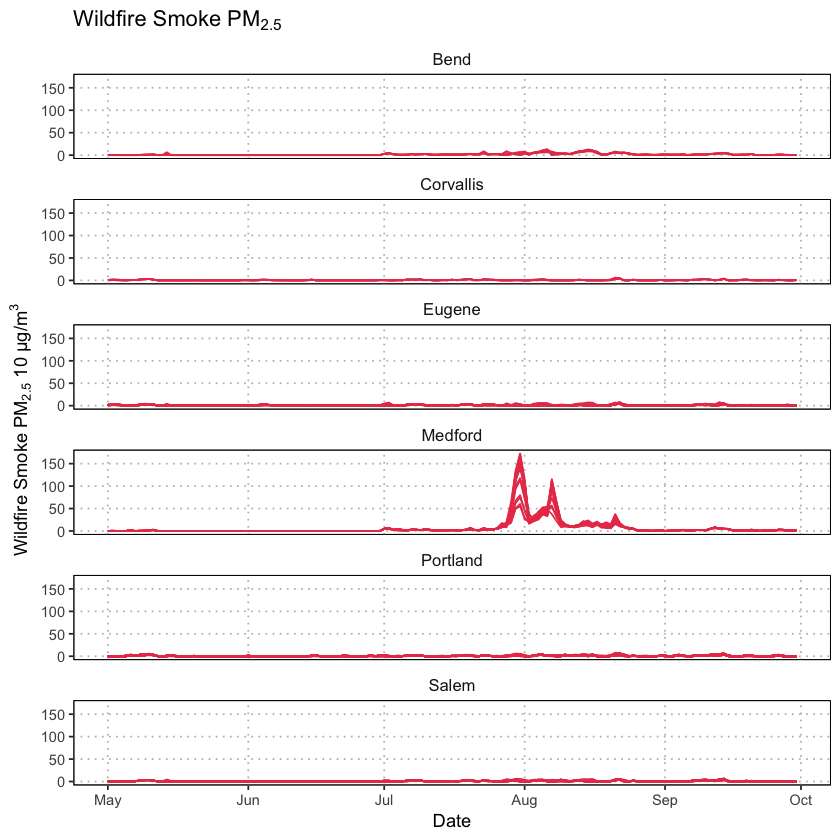

In [12]:
# plot of pm by msa
pm_msa_plot <- ggplot(data = msa_pm, aes(x = date, y = geo_smk_pm, group = ZIPCODE)) +
    geom_line(color = '#e94057') +
    # facet by metro area
    facet_wrap(~metroarea, ncol = 1) +
    # y label
    ylab(expression(paste("Wildfire Smoke PM"[2.5]," 10 µg/m"^3))) +
    # x label
    xlab("Date") +
    ggtitle(expression(paste('Wildfire Smoke PM'[2.5]))) +
    theme(panel.background = element_rect(fill = 'white', colour = 'black'),
        panel.grid.major = element_line(color = 'grey', linetype = 'dotted',
                                        size = 0.5),
        panel.grid.minor = element_blank(),
        # strip element
        strip.background = element_rect(colour=NA, fill=NA),
        panel.border = element_rect(fill = NA, color = "black"),
        # facet text size
        strip.text = element_text(size = 10),
        axis.title.y = element_text(angle = 90))

pm_msa_plot

In [13]:
# check smoke by msa and with smoke > 15 ug/m^3
xtabs(~metroarea + smk15, msa_pm)

           smk15
metroarea       0     1
  Bend        918     0
  Corvallis   765     0
  Eugene     5049     0
  Medford    2049   246
  Portland  14382     0
  Salem      4590     0

Plotting binary smoke > 15 ug/m^3 to see how well it lines up with the continuous time series. I think this cutoff looks appropriate for the question we want to ask. **However, one limitation to this strict cutoff is that I won't have variability in the other cities to fit a difference in difference model. I do think I could just calculate the effect of smoke for a city though.**

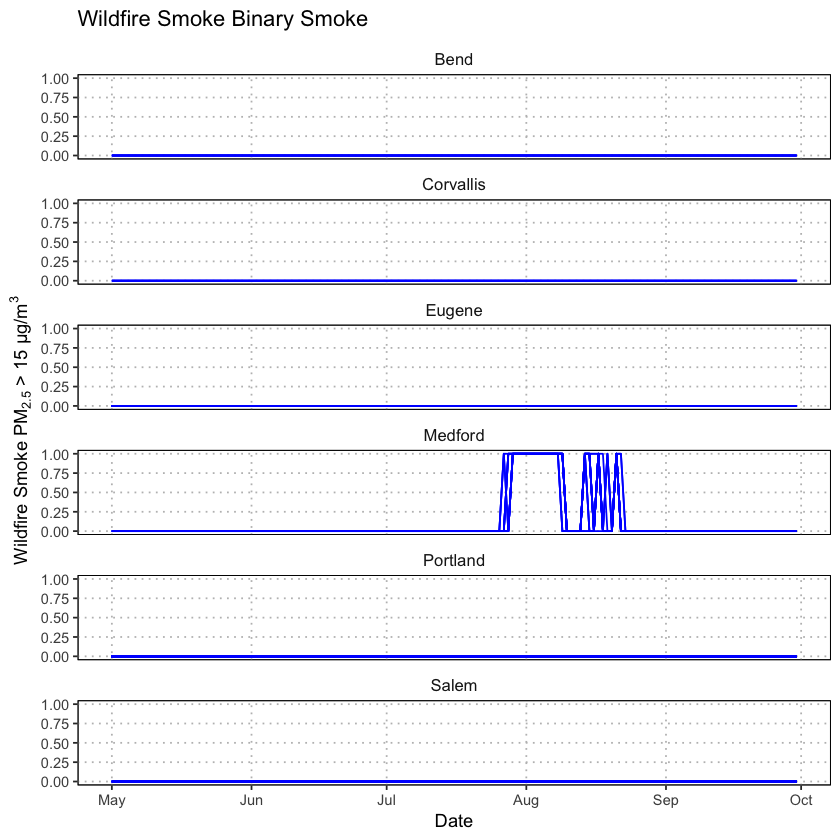

In [14]:
# binary smoke plot
# plot of pm by msa
smk_msa_plot <- ggplot(data = msa_pm, aes(x = date, y = smk15, group = ZIPCODE)) +
    geom_line(color = 'blue') +
    # facet by metro area
    facet_wrap(~metroarea, ncol = 1) +
    # y label
    ylab(expression(paste("Wildfire Smoke PM"[2.5]," > 15 µg/m"^3))) +
    # x label
    xlab("Date") +
    ggtitle(expression(paste('Wildfire Smoke Binary Smoke'))) +
    theme(panel.background = element_rect(fill = 'white', colour = 'black'),
        panel.grid.major = element_line(color = 'grey', linetype = 'dotted',
                                        size = 0.5),
        panel.grid.minor = element_blank(),
        # strip element
        strip.background = element_rect(colour=NA, fill=NA),
        panel.border = element_rect(fill = NA, color = "black"),
        # facet text size
        strip.text = element_text(size = 10),
        axis.title.y = element_text(angle = 90))

smk_msa_plot

## Join PM<sub>2.5</sub> with Asthma Outcomes Count

Joining two dataframes together to make a time series dataframe. I need to replicate the PM and smoke series for each outcome so I don't have gaps in my time series.

In [42]:
# vector of service place
service_place <- unique(asthma_pos_count$service_place)
# vector of msa
metroarea <- sort(unique(msa_pm$metroarea))
# vector of dates
date <- sort(unique(msa_pm$date))

In [52]:
# expand dates so I have equal number of dates for the time series by place of service
metro_dates <- expand.grid(date, metroarea, service_place) %>% 
    rename(date = Var1, metroarea = Var2, service_place = Var3) %>% 
    mutate(metroarea = as.character(metroarea),
           service_place = as.character(service_place))

In [53]:
# check place of service
glimpse(metro_dates)

Observations: 6,426
Variables: 3
$ date          <date> 2013-05-01, 2013-05-02, 2013-05-03, 2013-05-04, 2013...
$ metroarea     <chr> "Bend", "Bend", "Bend", "Bend", "Bend", "Bend", "Bend...
$ service_place <chr> "Office", "Office", "Office", "Office", "Office", "Of...


In [54]:
# aggregate pm to msa
metro_smk <- msa_pm %>% 
    # groupby metroarea and date
    group_by(metroarea, date) %>% 
    # summarise values of pm2.5 smoke and binary smoke
    # using min for smoke where if any zipcode is exposed then msa had smoke
    summarize(smk15 = min(smk15), avg_smk_pm = mean(geo_smk_pm)) 

In [55]:
# view first couple rows
glimpse(metro_smk)

Observations: 918
Variables: 4
$ metroarea  <chr> "Bend", "Bend", "Bend", "Bend", "Bend", "Bend", "Bend", ...
$ date       <date> 2013-05-01, 2013-05-02, 2013-05-03, 2013-05-04, 2013-05...
$ smk15      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ avg_smk_pm <dbl> 7.945249e-03, 9.151923e-02, 4.970961e-02, 0.000000e+00, ...


In [57]:
glimpse(asthma_pos_count)

Observations: 4,192
Variables: 4
$ date          <date> 2013-05-01, 2013-05-01, 2013-05-01, 2013-05-01, 2013...
$ metroarea     <chr> "Bend", "Corvallis", "Eugene", "Medford", "Not in MSA...
$ service_place <chr> "Office", "Office", "Office", "Office", "Office", "Of...
$ n_events      <dbl> 20, 11, 72, 32, 97, 213, 45, 12, 7, 69, 29, 91, 187, ...


In [125]:
# join smoke values and populations to asthma smoke
asthma_smk_ts <- metro_dates %>% 
    left_join(asthma_pos_count, by = c('date', 'metroarea', 'service_place')) %>% 
    # set missing value to 0
    mutate(n_events = ifelse(is.na(n_events), 0, n_events)) %>% 
    # merge population values
    left_join(population, by = 'metroarea') %>% 
    # merge smoke values
    left_join(metro_smk, by = c('metroarea', 'date')) %>% 
    # identify day and weekend
    mutate(day = lubridate::wday(date, label = T), 
           weekend = ifelse(day %in% c('Sat', 'Sun'), 1, 0), 
           month = as.factor(lubridate::month(date)))

In [126]:
# view first couple rows
head(asthma_smk_ts)

date,metroarea,service_place,n_events,pop,smk15,avg_smk_pm,day,weekend,month
2013-05-01,Bend,Office,20,165270,0,7.945249e-03,Wed,0,5
2013-05-02,Bend,Office,12,165270,0,9.151923e-02,Thu,0,5
2013-05-03,Bend,Office,15,165270,0,4.970961e-02,Fri,0,5
2013-05-04,Bend,Office,2,165270,0,0.000000e+00,Sat,1,5
2013-05-05,Bend,Office,4,165270,0,7.421256e-07,Sun,1,5
2013-05-06,Bend,Office,18,165270,0,2.700339e-04,Mon,0,5


In [127]:
glimpse(asthma_smk_ts)

Observations: 6,426
Variables: 10
$ date          <date> 2013-05-01, 2013-05-02, 2013-05-03, 2013-05-04, 2013...
$ metroarea     <chr> "Bend", "Bend", "Bend", "Bend", "Bend", "Bend", "Bend...
$ service_place <chr> "Office", "Office", "Office", "Office", "Office", "Of...
$ n_events      <dbl> 20, 12, 15, 2, 4, 18, 15, 17, 15, 3, 0, 0, 19, 10, 14...
$ pop           <int> 165270, 165270, 165270, 165270, 165270, 165270, 16527...
$ smk15         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ avg_smk_pm    <dbl> 7.945249e-03, 9.151923e-02, 4.970961e-02, 0.000000e+0...
$ day           <ord> Wed, Thu, Fri, Sat, Sun, Mon, Tue, Wed, Thu, Fri, Sat...
$ weekend       <dbl> 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,...
$ month         <fct> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...


## Time Series Analysis

Analysis of the effect of smoke on outcomes. Starting off by plotting daily time series for each event.

### Time series plot for places of service by metroarea 

Plotting time series of rates for all the outcomes considered by metroarea. It's a little dense to read so I'm going to plot just the SABA inhaler fills.

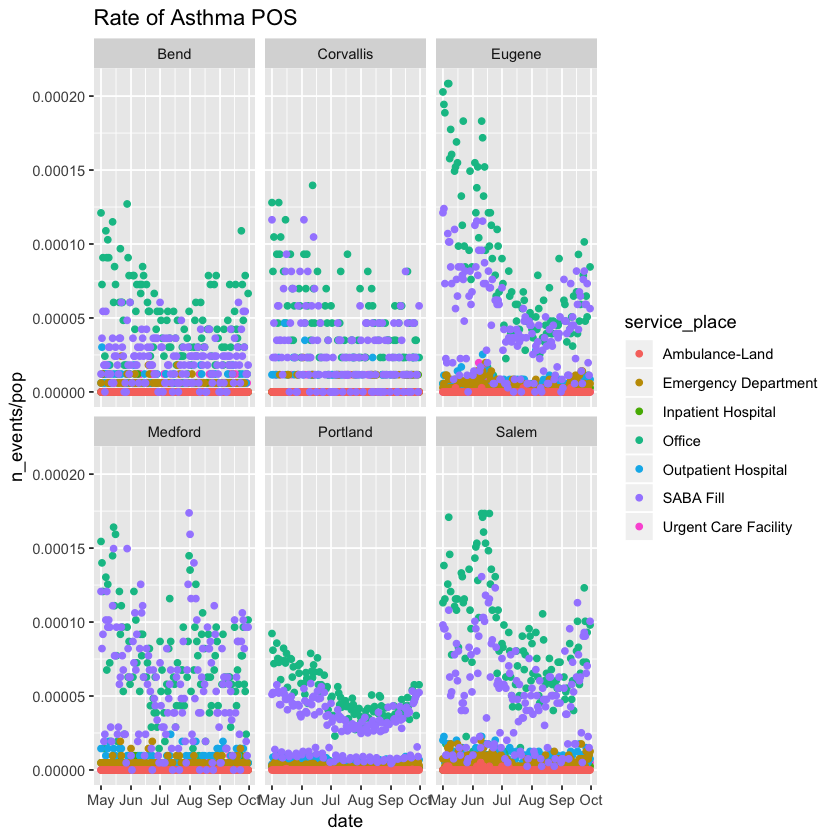

In [142]:
ggplot(asthma_smk_ts, aes(x = date, y = n_events/pop, color = service_place)) +
    geom_point() +
    facet_wrap(~metroarea) +
    ggtitle("Rate of Asthma POS")

### SABA Time Series and Analysis

Subsetting to SABA fills and plotting time series. In the more populated cities, I notice both a seasonal trend, trend by city, and a weekend vs. weekday trend. I will need to consider how to account for these in the analyses evaluating the effect of smoke on outcomes.

I also plan to work through a possible analytic strategy to assess the impact the smoke event had on asthma care utilization in the city of Medford.

In [129]:
saba <- filter(asthma_smk_ts, service_place == 'SABA Fill')

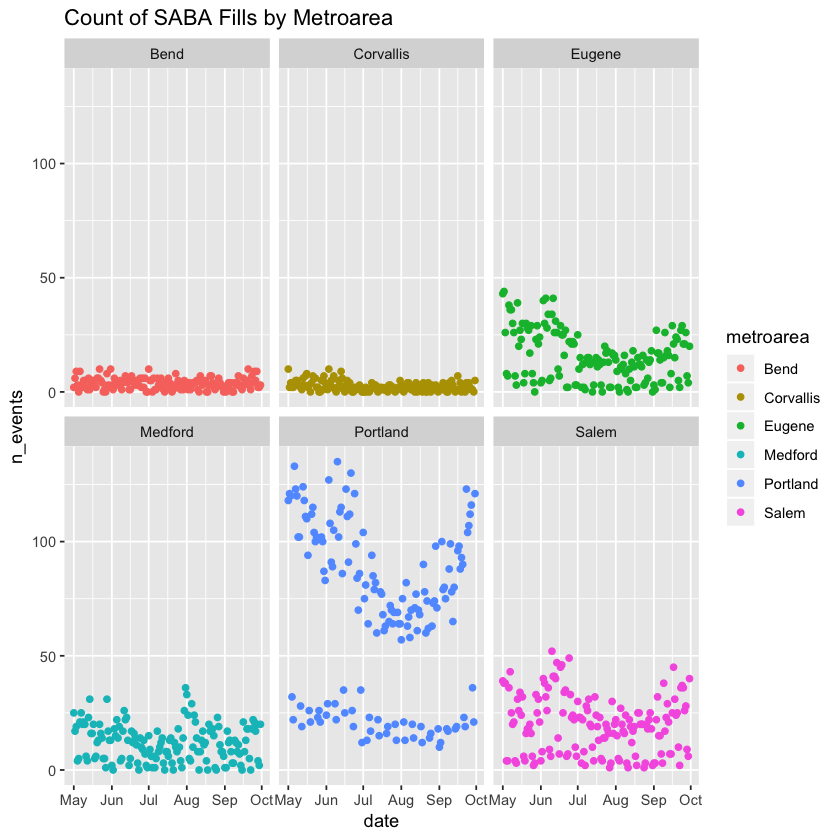

In [143]:
# plot of counts
ggplot(saba, aes(x=date, y = n_events, color = metroarea)) +
    geom_point() + 
    facet_wrap(~metroarea) +
    ggtitle("Count of SABA Fills by Metroarea")

Running a simple quasi-Poisson model on the rate of SABA events on days when smoke was >15 ug/m<sup>3</sup> above background levels, controlling for metroarea, month, and weekend. 

I could consider a more sophisticated model using a spline or other periodic function. It would be worth having this discussion with Ander and Sheryl. It is also possible that we could just run this association with smoke > 15 ug/m<sup>3</sup> in the time-stratified case-crossover design to avoid this issue. I would expect very similar results to this model, where on a given smoke day, the rate for a SABA fill is exp(0.74) or 2.10 times higher compared to non-smoke days.

In [150]:
# running no intercept quasipoisson model
mod <- glm(n_events ~ -1 + smk15 + metroarea + month + weekend + offset(log(pop)), 
           family = "quasipoisson"(link='log'), data = saba)

In [151]:
summary(mod)


Call:
glm(formula = n_events ~ -1 + smk15 + metroarea + month + weekend + 
    offset(log(pop)), family = quasipoisson(link = "log"), data = saba)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-10.3950   -1.0030   -0.1037    0.8022    3.8493  

Coefficients:
                    Estimate Std. Error  t value Pr(>|t|)    
smk15                0.74032    0.09798    7.556 1.02e-13 ***
metroareaBend      -10.30479    0.06238 -165.184  < 2e-16 ***
metroareaCorvallis -10.06176    0.07554 -133.194  < 2e-16 ***
metroareaEugene     -9.59427    0.03373 -284.436  < 2e-16 ***
metroareaMedford    -9.40146    0.03933 -239.043  < 2e-16 ***
metroareaPortland   -9.98225    0.02250 -443.716  < 2e-16 ***
metroareaSalem      -9.46001    0.03095 -305.617  < 2e-16 ***
month6               0.02800    0.02955    0.948    0.344    
month7              -0.42858    0.03252  -13.181  < 2e-16 ***
month8              -0.43444    0.03308  -13.135  < 2e-16 ***
month9              -0.16774   

### Estimates of Event Counts Due to Smoke

The way this model is set up, there is no variability in smoke in other metroareas besides Medford, so I can just use the smk15 estimate and the background average rate of SABA fills in Medford, which is the e<sup>-9.4</sup> estimate x 207155 population of Medford.

In [180]:
# avg SABA fill rate from May to September in Medford
base_rate <- broom::tidy(mod) %>% 
    filter(term == 'metroareaMedford') %>% 
    # calculate rates for Medford
    mutate(lower95 = estimate - (1.96*std.error), 
           upper95 = estimate + (1.96*std.error), 
           rate = exp(estimate)*207155, 
           low_rate = exp(lower95)*207155, 
           up_rate = exp(upper95)*207155)


base_rate

term,estimate,std.error,statistic,p.value,lower95,upper95,rate,low_rate,up_rate
metroareaMedford,-9.401459,0.03932959,-239.0429,0,-9.478545,-9.324373,17.11172,15.84221,18.48297


In [177]:
# calculating relative increase in rate for medford due to smoke
smk_rate <- broom::tidy(mod) %>% 
    filter(term == 'smk15') %>% 
    mutate(smk_rate = exp(estimate)*base_rate$rate)

smk_rate

term,estimate,std.error,statistic,p.value,smk_rate
smk15,0.740315,0.0979763,7.556062,1.015446e-13,35.87637


Number of smoke days based on >15 ug/m<sup>3</sup> definition is 12.

In [240]:
# number of smoke days in each MSA
xtabs(~ smk15 + metroarea, metro_smk)

     metroarea
smk15 Bend Corvallis Eugene Medford Portland Salem
    0  153       153    153     141      153   153
    1    0         0      0      12        0     0

The average rate on the smoke day is 35.9, which is around 2 times higher than the base rate of 17.1. The average number of SABA fills that may be attributed to wildfire smoke (assuming causal relationship) would be 18.8 (difference in rates). There were also 12 days where smoke was > 15 ug/m<sup>3</sup>. Therefore, we may be able to attribute 226 SABA fills to the smoke event in Medford (12 x 18.8).

There is some uncertainy around each estimate. I'm going to use an adaptation of the health impact assessment formula and Monte Carlo to estimate some bounds around these numbers.

### Monte Carlo Estimate of Difference Due to Medford Smoke Event

Assuming normal distributions with a mean represented by the estimate and standard deviation represented by standard error.

In [197]:
# monte carlo
# set seed 
sim_seed <- 123

# number of iterations for MC
n <- 10000

# set params
med_rate <- base_rate$estimate
med_rate_error <- base_rate$std.error

# rate distribution; calculating rate for medford
rate_dist <- exp(rnorm(n, mean = med_rate, sd = med_rate_error))*207155

# beta estimate
smk_beta <- smk_rate$estimate
smk_error <- smk_rate$std.error
# calculation of possible relative rate differences based on normal distribution
smk_dist <- exp(rnorm(n, mean = smk_beta, sd = smk_error))

Plot of daily base rate of SABA fills in Medford.

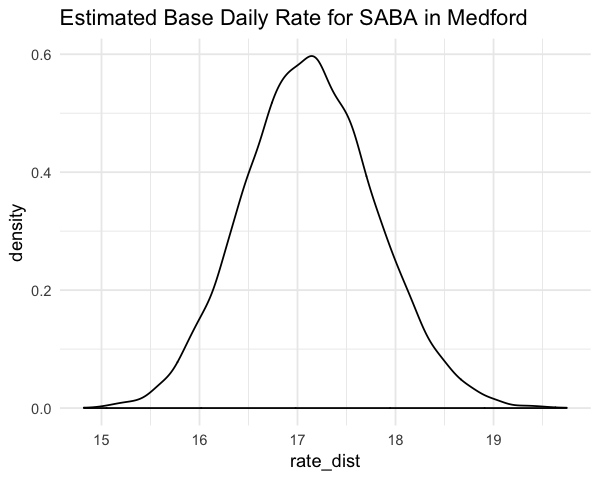

In [213]:
# set plot options
options(repr.plot.width = 5, repr.plot.height = 4)

# checking distribution of estimated baseline rate
ggplot(as.data.frame(rate_dist), aes(x = rate_dist)) +
    geom_density() + 
    ggtitle('Estimated Base Daily Rate for SABA in Medford') +
    theme_minimal()

In [225]:
# empty vector for difference
diff_vec <- vector('double', length = n)

# simple monte carlo calculation
for(i in 1:n){
    # calculate expected difference of rate on smoke day - rate on non-smoke day
    diff_vec[[i]] <- ((sample(rate_dist, 1, replace = T)*sample(smk_dist, 1, replace = T)) - 
                      sample(rate_dist, 1, replace = T))*12
    }

median_diff <- as.numeric(quantile(diff_vec, 0.5))
lower95_diff <- as.numeric(quantile(diff_vec, 0.025))
upper95_diff <- as.numeric(quantile(diff_vec, 0.975))

In [248]:
# printing out median and 95%CI estimates for difference over the 12 day period
data.frame(median_diff, lower95_diff, upper95_diff)

median_diff,lower95_diff,upper95_diff
225.947,144.6064,326.2256


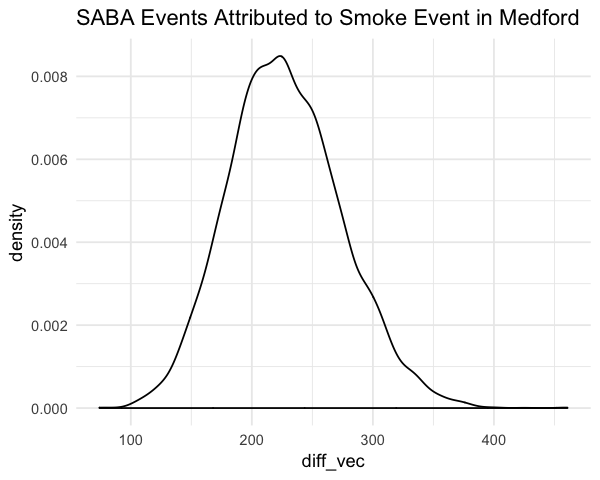

In [218]:
# plot difference vector
options(repr.plot.width = 5, repr.plot.height = 4)

# checking distribution of estimated baseline rate
ggplot(as.data.frame(diff_vec), aes(x = diff_vec)) +
    geom_density() + 
    ggtitle('SABA Events Attributed to Smoke Event in Medford') +
    theme_minimal()

The estimated median difference of the number of SABA fills that may be attributed to the smoke event in Medford of 225 seems reasonable if you eyeball the figure. The bounds of 144 and 326 also seem reasonable. I'm going to calculate the expected difference for the other outcomes as well.

## Estimated Difference in Asthma Care Utilization in Medford by Place of Service

Following code chunks and section applies the process I outlined above for all places of service. These results would go in the paper.

In [286]:
# define custom function to find the difference using monte carlo when a dataframe is provided
mc_diff <- function(df, mc_n){
    # service place
    service_place <- as.character(df$service_place[1])
    # run model on dataframe
    mod <- broom::tidy(glm(n_events ~ -1 + smk15 + metroarea + month + weekend + offset(log(pop)), 
           family = "quasipoisson"(link='log'), data = df))
    
    # output terms for MC estimate
    n <- mc_n
    # set medford params
    med_rate <- filter(mod, term == 'metroareaMedford')$estimate
    med_rate_error <- filter(mod, term == 'metroareaMedford')$std.error
    # rate distribution; calculating rate for medford
    rate_dist <- exp(rnorm(n, mean = med_rate, sd = med_rate_error))*207155

    # beta estimate
    smk_beta <- filter(mod, term == 'smk15')$estimate
    smk_error <- filter(mod, term == 'smk15')$std.error
    # calculation of possible relative rate differences based on normal distribution
    smk_dist <- exp(rnorm(n, mean = smk_beta, sd = smk_error))
    # empty vector for difference
    diff_vec <- vector('double', length = n)

    # simple monte carlo calculation
    for(i in 1:n){
        # calculate expected difference of rate on smoke day - rate on non-smoke day
        diff_vec[[i]] <- ((sample(rate_dist, 1, replace = T)*sample(smk_dist, 1, replace = T)) - 
                          sample(rate_dist, 1, replace = T))*12
        }

    median_diff <- as.numeric(quantile(diff_vec, 0.5, na.rm = T))
    lower95_diff <- as.numeric(quantile(diff_vec, 0.025, na.rm = T))
    upper95_diff <- as.numeric(quantile(diff_vec, 0.975, na.rm = T))
    
    # return dataframe of service place and estimated difference due to medford smoke
    data.frame(service_place, median_diff, lower95_diff, upper95_diff) %>% 
        mutate(service_place = as.character(service_place))
                       }

In [283]:
# test out mc function
mc_diff(saba, mc_n = 10000)

service_place,median_diff,lower95_diff,upper95_diff
SABA Fill,224.0143,142.4266,324.3643


In [287]:
# run esimtated difference due to the medford smoke event for each place of service
diff_results <- asthma_smk_ts %>% 
    # filter out ambulance visits
    filter(service_place != 'Ambulance-Land') %>% 
    split(.$service_place) %>% 
    map_dfr( ~ mc_diff(.x, mc_n = 10000))

### 2013 Smoke Impact on Asthma Care in Medford Table

Table of the estimated events that could be due to smoke over a 12 day period in Medford. I'd interpret the following as the smoke event only really had a noticeable effect on office and SABA fills. It's possible there were a couple inpatient admissions that may be due to this as well. One issue that may 

In [288]:
# print out the estimated difference
diff_results

service_place,median_diff,lower95_diff,upper95_diff
Emergency Department,4.1593411,-3.8483559,21.83164
Inpatient Hospital,4.4929316,-1.4235529,19.35719
Office,157.3466684,55.2973666,285.79058
Outpatient Hospital,5.0353385,-7.2691970,27.59885
SABA Fill,225.5811985,142.2179691,327.58538
Urgent Care Facility,0.6800722,-0.9739851,14.01731


## Discussion/Feedback

In our last meeting, Ander, Sheryl, and myself decided on an alternative strategy for trying to estimate the impact of the wildfire smoke event in Medford that took place over a couple weeks in 2013. Instead of a difference in difference  for monthly counts within each metroarea, we decided to use a Poisson model of daily counts, and evaluate the effect of a binary indicator of smoke exposure. Based on this model, we'd then estimate the impact of the smoke event in Medford using an HIA. I've sort of side stepped some parts of the HIA formula because it can be estimated from the model itself.

Below are a couple of issues I'd like to discuss to finalize this process.

1. Model family: I decided on quasi-Poisson to handle 0 values on days for some of the less common place of service like ED.

2. Binary smoke classifier of > 15 ug/m<sup>3</sup>: This has results in zero variance for other metroareas, hence I was not able to run an interaction model. I actually do not have a problem with this as it made the modeling simpler as I did not have to calculate differences of differences. That said, we could have just modeled Medford only. This leads in to a couple more considerations.

    a. Should I consider a different cutoff for the classifier? 
    b. Or do we want to approach this from a difference in difference model where I just code the time period of interest and contrasts the difference?

3. Given this time series approach, it seems like we could alternatively follow an HIA and use the beta from the conditional logistic regression model estimates and concentrations of smoke. Although, I like that this binary cutoff and time series is straight-forward.

4. Controlling for seasonal confounding: I have a very simple model adjusted for a couple things as a first step to figuring out the modeling approach. Should I consider adding a periodic function or a spline to try and estimate the number of events that would have occurred had the smoke not occurred? Right now, I use the seasonal average for Medford as the baseline rate. This could also possibly explain why I don't see anything with the less common events since I'm averaging over a possible seasonal dip?

5. This might be more of a question for Ander, but does this HIA/Monte Carlo approach work for you? I was not aware or could not figure out how to estimate a difference in the model directly, so I used pieces of information from it.